In [19]:
import numpy as np
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_euler, integrator_leapfrog, integrator_rungekutta, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_direct_vectorized , acceleration_direct, acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
from numpy.random import random, seed
from fireworks.particles import Particles
from fireworks.nbodylib.timesteps import adaptive_timestep_simple, adaptive_timestep_r

from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

Let's put in the particles (rebember that the units are Nbody units).

In [2]:
tevolve    = 65
position   = np.array([[0.,0.,0.],[0.5, 0.866,0],[1,0,0]])
velocity   = np.array([[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
mass       = np.array([3.,4.,5.])
P          = Particles(position,velocity,mass)
print(P.pos )                                                                  # particles'positions
print(P.vel )                                                                  # particles'velocities
print(P.mass)                                                                  # particles'masses
print(P.ID  )                                                                  # particles'unique IDs


[[0.    0.    0.   ]
 [0.5   0.866 0.   ]
 [1.    0.    0.   ]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[3. 4. 5.]
[0 1 2]


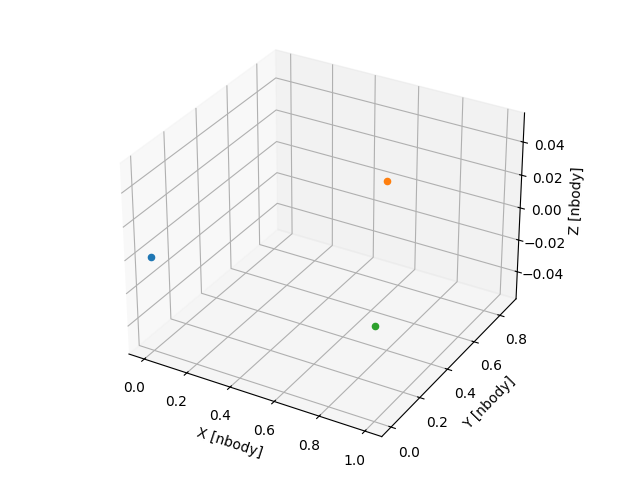

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(P.pos[0,0], P.pos[0,1], P.pos[0,2], label=f'$M_1$', color='C0')
ax.scatter(P.pos[1,0], P.pos[1,1], P.pos[1,2], label=f'$M_2$', color='C1')
ax.scatter(P.pos[2,0], P.pos[2,1], P.pos[2,2], label=f'$M_3$', color='C2')
ax.set_xlabel('X [nbody]')
ax.set_ylabel('Y [nbody]')
ax.set_zlabel('Z [nbody]')

plt.tight_layout()
plt.show()

### TSUNAM EVOLUTION

Now we can evolve the system using the TSUNAMI integrator. 

As initial condition we put $t_{start} = 0$ and $t_{simulation} = t_{evolve} = 65$ defined previously. To perform the integration we devide this interval in $n = METTERE QUANTO$ parts linearly spaced.

In [4]:
def integration_with_tsunami_3body(part, tsimulation):
    tstart=0
    tintermediate = np.linspace(tstart, tsimulation, 13)
    tcurrent=0
    pos1_tsu = []
    pos2_tsu = []
    pos3_tsu = []
    #Epot_tsu = []
    #Ekin_tsu = []
    #Etot_tsu = []
    t_tsunami = []

    for t in tintermediate:
        tstep=t-tcurrent
        if tstep <=0: continue 
        part_tsunami, efftime,_,_,_=integrator_tsunami(part, tstep)

        #I append the positions
        pos1_tsu.append(part_tsunami.pos[0].copy())
        pos2_tsu.append(part_tsunami.pos[1].copy())
        pos3_tsu.append(part_tsunami.pos[2].copy())

        #I append the energies
        #Etot_n, Ekin_n, Epot_n =  part_tsunami.Etot()
        #Etot_tsu.append(Etot_n)
        #Ekin_tsu.append(Ekin_n)
        #Epot_tsu.append(Epot_n)

        #I append the times
        t_tsunami.append(tcurrent)

        tcurrent=tcurrent+efftime

    #I transform everything in numpy arrays
    pos1_tsu    = np.array(pos1_tsu)
    pos2_tsu    = np.array(pos2_tsu)
    pos3_tsu    = np.array(pos3_tsu)
    #Epot_tsu    = np.array(Epot_tsu)
    #Ekin_tsu    = np.array(Ekin_tsu)
    #Etot_tsu    = np.array(Etot_tsu)
    t_tsunami   = np.array(t_tsunami)


    return pos1_tsu, pos2_tsu, pos3_tsu, t_tsunami #, Epot_tsu, Ekin_tsu, Etot_tsu

In [5]:
P_tsu = P.copy()

In [6]:
pos1_tsu, pos2_tsu, pos3_tsu, t_tsu = integration_with_tsunami_3body(P_tsu, tevolve)

In [7]:
print(pos1_tsu)
print(pos2_tsu)
print(pos3_tsu)

[[ 1026.4806206    193.57009097     0.        ]
 [ 2117.54331559   399.31884527     0.        ]
 [ 3208.60552367   605.06750778     0.        ]
 [ 4299.66788681   810.81619922     0.        ]
 [ 5390.73052878  1016.56494326     0.        ]
 [ 6481.7926904   1222.31359617     0.        ]
 [ 7572.85521015  1428.06231613     0.        ]
 [ 8663.91747033  1633.81098699     0.        ]
 [ 9754.97983119  1839.55967674     0.        ]
 [10846.04240556  2045.30840621     0.        ]
 [11937.10471422  2251.0570849      0.        ]
 [13028.16699136  2456.80575742     0.        ]]
[[ -342.16020209   -64.52332959     0.        ]
 [ -705.847764    -133.10620802     0.        ]
 [-1069.53516743  -201.68910624     0.        ]
 [-1433.22262038  -270.27198127     0.        ]
 [-1796.91016865  -338.85491109     0.        ]
 [-2160.59755514  -407.43773585     0.        ]
 [-2524.2850628   -476.02070725     0.        ]
 [-2887.9724889   -544.60365845     0.        ]
 [-3251.65993597  -613.1864323      0. 

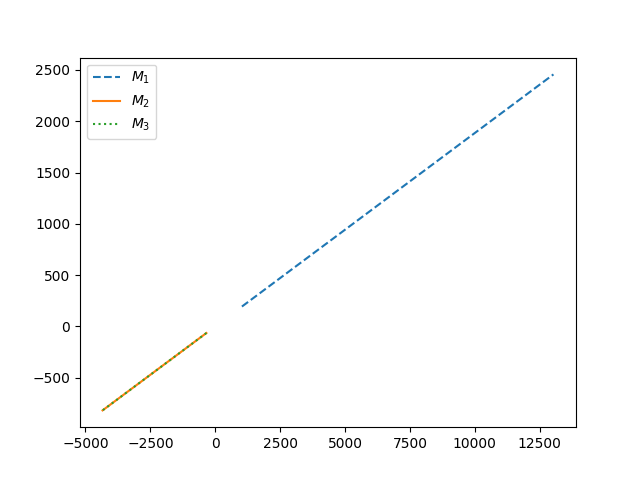

In [ ]:
plt.figure()
plt.plot(pos1_tsu[:,0], pos1_tsu[:,1], label=f'$M_1$', linestyle='dashed' ) # , pos1_tsu[:,2])
plt.plot(pos2_tsu[:,0], pos2_tsu[:,1], label=f'$M_2$') # , pos2_tsu[:,2])
plt.plot(pos3_tsu[:,0], pos3_tsu[:,1], label=f'$M_3$', linestyle='dotted' ) # , pos3_tsu[:,2])
plt.legend()
plt.show()

### OTHER INTEGRATORS

Let's begin with the `euler_integrator` and let's use the `acceleration_pyfalcon`. These are the fastest among the other analogous competitors.

In [21]:
def integration_euler_adaptive(part, h, tsimulation, t, N, softening):
    path_1 = []
    path_2 = []
    path_3 = []
    time   = []
    time2  = []
    Etot_euler = []
    Ekin_euler = []
    Epot_euler = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_euler(part, h, acceleration_pyfalcon, softening)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            path_3.append(updated_part.pos[2])

            '''
            Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            Etot_euler.append(Etot_n)
            Ekin_euler.append(Ekin_n)
            Epot_euler.append(Epot_n)
            '''
        
        ts_1, _, _ = adaptive_timestep_r(part)
        h = ts_1
        time.append(h)
        t += h
        time2.append(t)
    
        #print('h = ', h)
        #print('t = ', t)

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    path_3 = np.array(path_3)
    time   = np.array(time)
    time2  = np.array(time2)
    #Etot_euler = np.array(Etot_euler)
    #Ekin_euler = np.array(Ekin_euler)
    #Etot_euler = np.array(Epot_euler)

    return path_1, path_2, path_3



In [14]:
def integration_euler(part, h, tsimulation, t, N, softening):
    path_1 = []
    path_2 = []
    path_3 = []
    #Etot_euler = []
    #Ekin_euler = []
    #Epot_euler = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_euler(part, h, acceleration_pyfalcon, softening)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            path_3.append(updated_part.pos[2])
            #Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            #Etot_euler.append(Etot_n)
            #Ekin_euler.append(Ekin_n)
            #Epot_euler.append(Epot_n)

        t += h

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    path_3 = np.array(path_3)
    #Etot_euler = np.array(Etot_euler)
    #Ekin_euler = np.array(Ekin_euler)
    #Etot_euler = np.array(Epot_euler)

    return path_1, path_2, path_3 #, Etot_euler, Ekin_euler, Epot_euler

In [22]:
P_euler = P.copy()
h = 1
N = 3
t = 0
softening = 0

path_1_euler, path_2_euler, path_3_euler = integration_euler_adaptive(P_euler, h, tevolve, t, N, softening)

In [23]:
print(path_1_euler)

[[   0.            0.            0.        ]
 [   7.00013256    3.46422863    0.        ]
 [   7.00622213    3.46724224    0.        ]
 ...
 [1819.81548634  900.59110597    0.        ]
 [1821.63435601  901.49122901    0.        ]
 [1823.45322567  902.39135205    0.        ]]


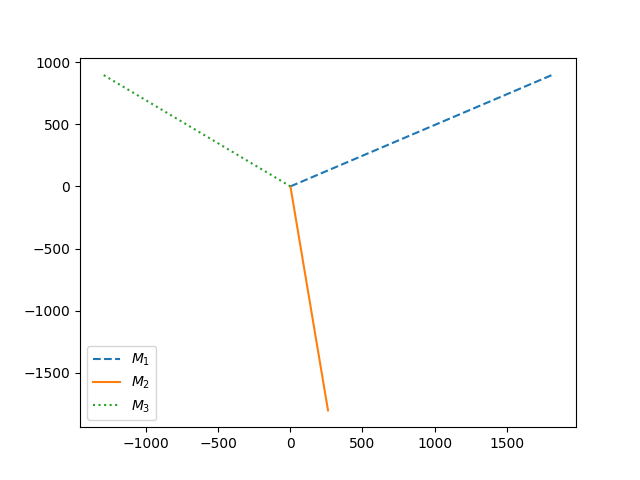

In [24]:
plt.figure()
plt.plot(path_1_euler[:,0]  , path_1_euler[:,1], label=f'$M_1$', linestyle='dashed' ) # , pos1_tsu[:,2])
plt.plot(path_2_euler[:,0]  , path_2_euler[:,1], label=f'$M_2$') # , pos2_tsu[:,2])
plt.plot(path_3_euler[:,0]  , path_3_euler[:,1], label=f'$M_3$', linestyle='dotted' ) # , pos3_tsu[:,2])
plt.legend()
plt.show()

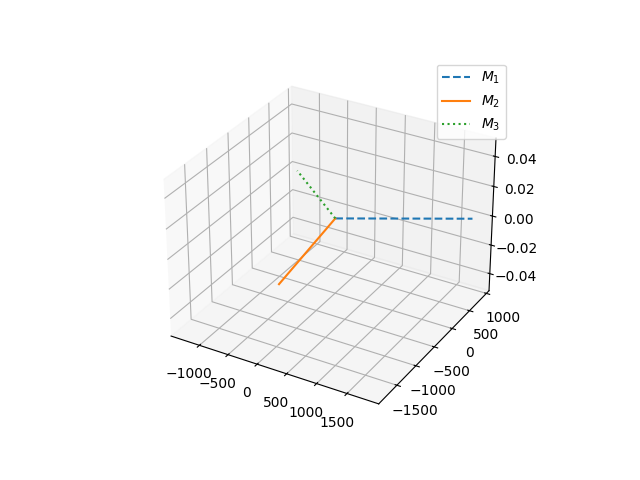

In [18]:
plt.figure()
ax = plt.axes(projection='3d')
plt.plot(path_1_euler[:,0], path_1_euler[:,1], path_1_euler[:,2], label=f'$M_1$', linestyle='dashed' ) # , pos1_tsu[:,2])
plt.plot(path_2_euler[:,0], path_2_euler[:,1], path_2_euler[:,2], label=f'$M_2$') # , pos2_tsu[:,2])
plt.plot(path_3_euler[:,0], path_3_euler[:,1], path_3_euler[:,2], label=f'$M_3$', linestyle='dotted' ) # , pos3_tsu[:,2])
plt.legend()
plt.show()